<a href="https://colab.research.google.com/github/Jina-yu/credit-now/blob/sihyeon/sihyeon_tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
root_dir = '/content/drive/MyDrive/credit-now' if os.getcwd().split('/')[-1] != 'credit-now' else './'
os.chdir(root_dir)

In [ ]:
os.getcwd()

'/content/drive/My Drive/credit-now'

In [ ]:
!pip uninstall -y typing # this should avoid  AttributeError: type object 'Callable' has no attribute '_abc_registry'

!pip install  "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

  Cloning https://github.com/dreamquark-ai/tabnet.git (to revision develop) to /tmp/pip-install-hxxhfwsu/pytorch-tabnet_e5a385dfa8f4450ba96628f7670d1614
  Running command git clone -q https://github.com/dreamquark-ai/tabnet.git /tmp/pip-install-hxxhfwsu/pytorch-tabnet_e5a385dfa8f4450ba96628f7670d1614
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from tensorflow.keras import models, layers, utils
import torch

import credit_data

In [ ]:
train_data, test_data, train_label, test_label = credit_data.load_data(name='train', encoding=False)
print(train_data.shape, test_data.shape, train_label.shape, test_label.shape)
train_data.head()

(15906, 17) (6818, 17) (15906, 1) (6818, 1)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,age,employed_year,work_phone,phone,email,occyp_type,family_size,begin_year
419,1,1,0,0,360000.0,0,1,0,0,34.361644,11.936986,1,1,1,4,2,2.000000
1082,0,0,1,0,126000.0,2,0,0,3,45.180822,0.000000,0,0,0,0,2,0.916667
10725,0,1,0,1,351000.0,1,0,0,0,44.227397,23.230137,0,0,0,12,3,1.083333
20755,1,1,0,0,225000.0,1,0,0,0,41.432877,7.871233,0,1,0,3,2,1.583333
8348,0,1,1,1,112500.0,0,0,0,0,44.394521,2.534247,1,1,0,5,3,4.750000



## Tabnet의 Optimizer를 다양하게 시도 
### Adam & max_epochs = 100 
- train accuracy: 0.7143845089903181
- test accuracy: 0.6752713405690819

### Adam & max_epochs = 500 
- train accuracy: 0.7438702376461712
- test accuracy: 0.6752713405690819

### Adagrad & max_epochs = 100 
- train accuracy: 0.6945806613856407
- test accuracy: 0.6881783514227046

### Adagrad & max_epochs = 500
- train accuracy: 0.7438702376461712
- test accuracy: 0.6752713405690819

### Adagrad & max_epochs = 500
- train accuracy: 0.7058971457311706
- test accuracy: 0.6884716925784687

### RMSprop & max_epochs = 100
- train accuracy: 0.6986043002640513
- test accuracy: 0.6745379876796714

### RMSprop & max_epochs = 500
- train accuracy: 0.7319250597258896
- test accuracy: 0.6714579055441479

In [ ]:
columns = train_data.columns.tolist()
categorical_columns = list()
# numeric_columns = ['income_total','age','employed_year','begin_year']
# categorical_columns = [columns for columns in columns if columns not in numeric_columns]
cat_idxs = [i for i, column in enumerate(columns) if column in categorical_columns]
cat_dims = [train_data[column].max() for column in columns if column in categorical_columns]

In [ ]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adagrad, 
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,"gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax',
                                lambda_sparse=0)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
max_epochs = 500
clf.fit(
    X_train=np.array(train_data), y_train=train_label,
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.95605 |  0:00:00s
epoch 1  | loss: 0.89554 |  0:00:00s
epoch 2  | loss: 0.88125 |  0:00:01s
epoch 3  | loss: 0.87216 |  0:00:01s
epoch 4  | loss: 0.86597 |  0:00:02s
epoch 5  | loss: 0.86092 |  0:00:02s
epoch 6  | loss: 0.85584 |  0:00:03s
epoch 7  | loss: 0.85348 |  0:00:03s
epoch 8  | loss: 0.84998 |  0:00:03s
epoch 9  | loss: 0.848   |  0:00:04s
epoch 10 | loss: 0.84534 |  0:00:04s
epoch 11 | loss: 0.84309 |  0:00:05s
epoch 12 | loss: 0.84083 |  0:00:05s
epoch 13 | loss: 0.83897 |  0:00:06s
epoch 14 | loss: 0.83782 |  0:00:06s
epoch 15 | loss: 0.8363  |  0:00:07s
epoch 16 | loss: 0.83617 |  0:00:07s
epoch 17 | loss: 0.83388 |  0:00:07s
epoch 18 | loss: 0.83288 |  0:00:08s
epoch 19 | loss: 0.83086 |  0:00:08s
epoch 20 | loss: 0.83153 |  0:00:09s
epoch 21 | loss: 0.82979 |  0:00:09s
epoch 22 | loss: 0.82857 |  0:00:10s
epoch 23 | loss: 0.82708 |  0:00:10s
epoch 24 | loss: 0.82752 |  0:00:10s
epoch 25 | loss: 0.82697 |  0:00:11s
epoch 26 | loss: 0.82674 |  0:00:11s
e

In [ ]:
pred_train = np.array(clf.predict(np.array(train_data)),dtype=int).transpose()
pred_test = np.array(clf.predict(np.array(test_data)),dtype=int).transpose()
print('train accuracy:', accuracy_score(train_label, pred_train))
print('test accuracy:', accuracy_score(test_label, pred_test))

train accuracy: 0.7058971457311706
test accuracy: 0.6884716925784687


In [ ]:
# from pytorch_tabnet.metrics import LogLoss
# print('loss:', LogLoss(test_label, pred_test))

In [ ]:
clf.save_model('model_tabnet_adagrad_epoch500')

Successfully saved model at model_tabnet_adagrad_epoch500.zip


'model_tabnet_adagrad_epoch500.zip'

In [ ]:
loaded_clf = TabNetMultiTaskClassifier()
loaded_clf.load_model('models/model_tabnet_adagrad_epoch500.zip')

In [ ]:
feature_importance = clf.feature_importances_
feature_importance

array([0.03768467, 0.02420496, 0.04247652, 0.03063982, 0.03538551,
       0.04312345, 0.03720136, 0.03734099, 0.0297736 , 0.01652804,
       0.03695387, 0.04462455, 0.06600559, 0.04682837, 0.05498353,
       0.07737862, 0.33886654])

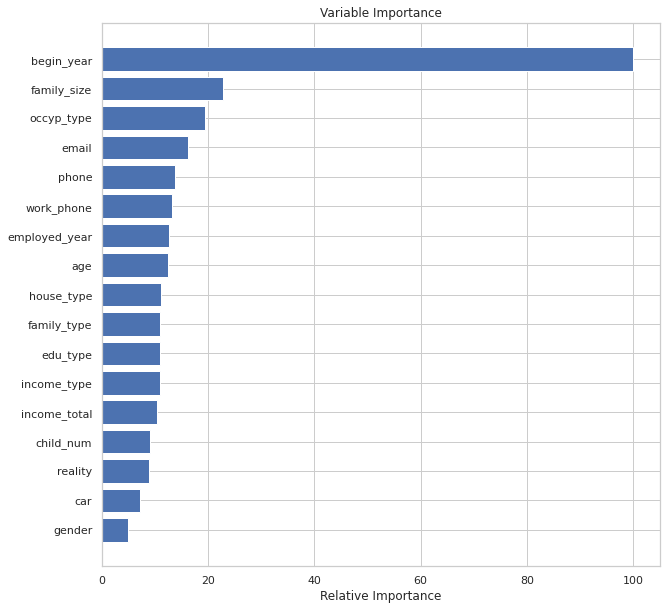

In [ ]:
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize = (10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('feature_importances_tabnet')
plt.show()